In [ ]:
# Running the Colab  Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Home Credit

## 1.1.Introduction to Home Credit Default Risk


*In countries where the financial markets are not very deep, people have difficulties getting loans easily. Due to insufficient or nonexistent credit history, they cannot get the loan easily.

*Home Credit is a financial company that strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. (We will call Home Credit shortly as HC) 

*Home Credit B.V. is an international non-bank financial institution founded in 1997 in the Czech Republic and headquartered in Netherlands.

*In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

*The company operates in 10 countries and focuses on installment lending primarily to people with little or no credit history. 

*The Home Credit loan can be obtained from throughout 342.700 partnering retail shops and shopping malls in ten world markets as well as at the Home Credit's own online marketplaces (Russia, China, Philippines and Vietnam). Home Credit is also presented online in its own mobile application or in a third-party online stores. In selected markets you can pay with a „HC Pay“, a QR code-based revolving credit or with Home Credit credit or shopping cards. Home Credit finances both the purchase of consumer goods through a cash-less loan transaction or other commodities, such as language courses, travel etc. through a cash loans. The loans are always issued in domestic currency of the market in which the brand operates.
 

Products of HC: 

-Point of Sale (POS) loans are offered to our customers for their purchases of goods and services at the point of sale (physical and online) and at the time of purchase.

-Cash loans are typically offered to our customers for consumer goods or services without a point of sale connection and, subject to local regulatory requirements, without specifying the goods or services to be purchased.

-Revolving loans, including credit cards, are typically offered to our existing customers for their purchases of goods or services up to individual credit limits on a revolving basis.


## 1.2. Aim of the Project

   
In this project, we try to contribute using Home Credit Data to forecast better for a credit application whether it will be paid or not. HC open a compatition on Kaggle. HC gives different types of data. Below you can find a short explanation about the data. Further we will deal with them in detail. 


-application_train/application_test: main data about the applicants. training data also includes Target variable indicating 0: the loan was repaid or 1: the loan was not repaid.

-bureau: This document contains data about applicants previous  credits from other financial institutions.  

-bureau_balance: This file contains monthly data about the previous credits in bureau.

-previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

-pos_cash_balance: monthly data about previous POS or cash loans with Home Credit  Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

-credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance.

-installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

The interrelation between dataframes is explained in table below.

![home_credit.png](attachment:home_credit.png)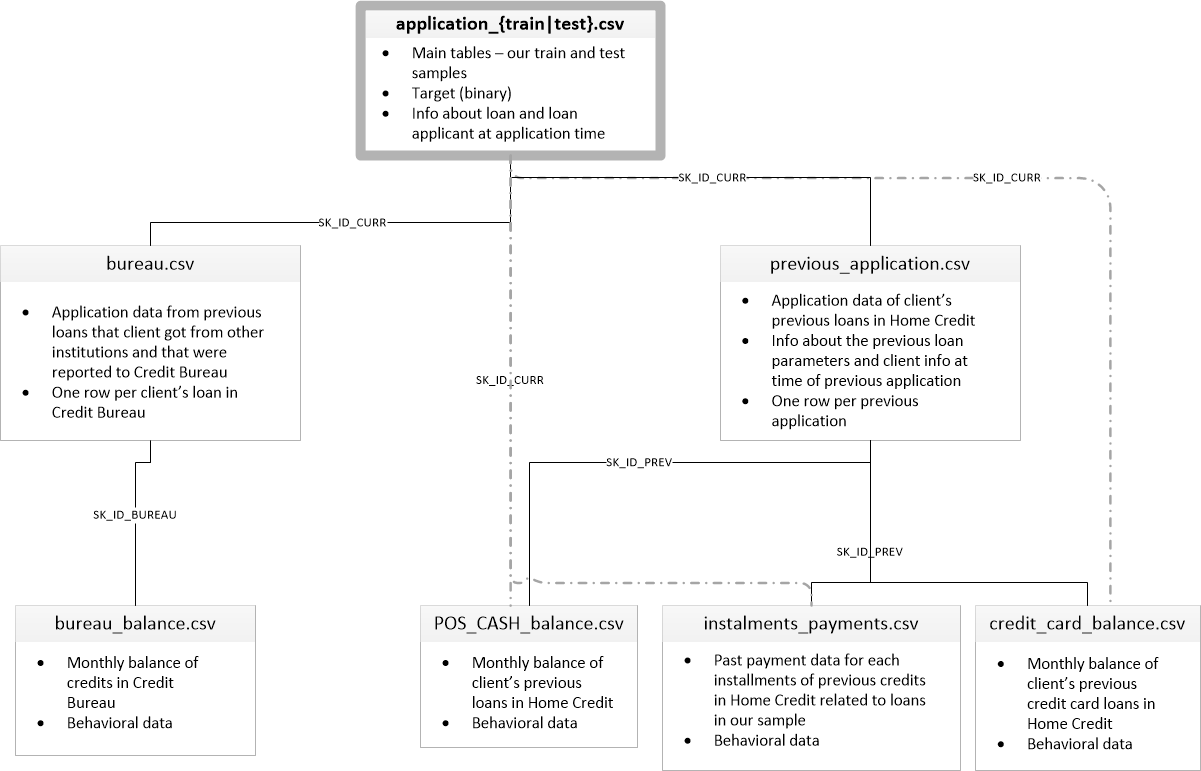

SK_ID_CURR is connecting the dataframes application_train|test with bureau, previous_application and also with dataframes POS_CASH_balance, installments_payment and credit_card_balance. SK_ID_PREV connects dataframe previous_application with POS_CASH_balance, installments_payment and credit_card_balance. SK_ID_BUREAU connects dataframe bureau with dataframe bureau_balance.

## Methodology

We obtain information about the data from Kaggle page. The description of the columns and dataframes is discussed in detail on Kaggle discussion pages.
For EDA we used basic Python libraries such as Pandas, Numpy and Matplotlib.
After feature engineering we merge all the dataframes together. In the end, we have a 974 variables. 
We used 2 types of models: XGBoost and LightGBM. 
We also calculate the feature importance. Almost 1/3 of variables have zero importance. We run LightGBM on both data: dropped and non-dropped versions. As expected, the dropped version gives better results.
Comparing these two models, XGBoost is much more slow than LightGBM. LightGBM gives higher accuracy and AUC score. We will see in detail in the end.

## Importing necessary libraries and application data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score,mean_squared_error, r2_score,classification_report
from sklearn.preprocessing import LabelBinarizer, LabelEncoder,StandardScaler
from sklearn.neighbors import LocalOutlierFactor
!pip install ycimpute
from ycimpute.imputer import EM
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
# from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
import re
import gc # we need this to clean memory after some heavy calculation
gc.collect()
# change the file path according to your working environment
file_path='/content/drive/MyDrive/Home Credit/home-credit-default-risk/'

In [ ]:
dfapptest=pd.read_csv(file_path + "application_test.csv")

dfapptest

## Useful Functions

We obtain some useful functions from different Kaggle codes related with HC. These functions help us to change numeric variables into aggreated form and categorical variables into dummies. Also we convert the data types into less memory demanding form.  

Altina aciklama yapilacak

In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Uniques', ascending=False))



In [ ]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client


In [ ]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [ ]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [ ]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [ ]:
#Function used for calculate aggregation statistics (mean, max, min, count) for numeraical variables

def agg_numeric2(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg


In [ ]:
# function for diminishing memory used. (optional) 
import sys

# def return_size(df):
#     """Return size of dataframe in gigabytes"""
#     return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
     
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

## 2.1.Application Data

At first, we handle the application data which contains 122 features.

In [ ]:
dfapptrain=pd.read_csv(file_path + "application_train.csv")
dfapptest=pd.read_csv(file_path + "application_test.csv")
dfapptrain['data_type'] = 'train'
dfapptest['data_type'] = 'test'
df = pd.concat([dfapptrain,dfapptest])
print('shape: ',df.shape)
df

shape:  (356255, 123)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,data_type
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,test
48740,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,test
48741,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,test
48742,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,test


In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(df).head(10)

,Total,Percent
COMMONAREA_MODE,248360,69.714109
COMMONAREA_MEDI,248360,69.714109
COMMONAREA_AVG,248360,69.714109
NONLIVINGAPARTMENTS_MEDI,246861,69.293343
NONLIVINGAPARTMENTS_MODE,246861,69.293343
NONLIVINGAPARTMENTS_AVG,246861,69.293343
FONDKAPREMONT_MODE,243092,68.235393
LIVINGAPARTMENTS_MEDI,242979,68.203674
LIVINGAPARTMENTS_AVG,242979,68.203674
LIVINGAPARTMENTS_MODE,242979,68.203674


In [ ]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)
    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)
    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    display(str.sort_values(by='Nulls', ascending=False))
summary(df)

Data shape: (356255, 123)
___________________________
Data Types:
float64    66
int64      40
object     17
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
COMMONAREA_AVG,float64,107895,3272,248360,0,1
COMMONAREA_MODE,float64,107895,3216,248360,0,1
COMMONAREA_MEDI,float64,107895,3290,248360,0,1
NONLIVINGAPARTMENTS_MODE,float64,109394,179,246861,0,1
NONLIVINGAPARTMENTS_MEDI,float64,109394,232,246861,0,1
...,...,...,...,...,...,...
FLAG_DOCUMENT_5,int64,356255,2,0,0,1
FLAG_DOCUMENT_4,int64,356255,2,0,0,1
FLAG_DOCUMENT_3,int64,356255,2,0,0,1
FLAG_DOCUMENT_21,int64,356255,2,0,0,1


Above function gives us crucial information about the data. There are both numerical and categorical variables in data. We have some nan-values which we look for a solution in further steps.    

In [ ]:
cor = df.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', cor.tail(10))
print('\nMost Negative Correlations:\n', cor.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


It seems that 'EXT_SOURCE' have highest correlation with Target variable. In Kaggle discussion, it is explained that EXT_SOURCE gives information about the applicants credit score and the resource of these data is unknown.

### 2.1.2.Feature Engineering 

We combine phone information in one column and drop the rest.

In [ ]:
df['PHONE'] = df[['FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']].sum(axis = 1)
df.drop(df[['FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']],axis=1,inplace=True)

We sum mismatched information and create a new column WRONG_ADRESS and drop the rest.

In [ ]:
df['WRONG_ADRESS'] = df[['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
                                         'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',
                                         'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']].sum(axis = 1)
df.drop(df[['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
            'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']],axis=1,inplace=True)

We combine flag_documents positive correlation and negative variables in two variables, and of course drop all.

In [ ]:
df['DOCUMENT_SUM_1'] = (df.loc[:,'FLAG_DOCUMENT_4':'FLAG_DOCUMENT_19'].sum(axis = 1))/(16) 
df['DOCUMENT_SUM_2'] = (df[['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']].sum(axis = 1))/(4) 
df.drop(df.loc[:,'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'],axis=1,inplace=True)

There are a number of information about the living area of the applicant. Also there are both sum, mean and median data of these data. We combine these data and drop the rest. 
 !!!! Extra explanation will come here!!!!

In [ ]:
df['BUILDING_FEATURES'] = (df.loc[:,'APARTMENTS_AVG':'NONLIVINGAREA_AVG'].sum(axis = 1))*(3-df['REGION_RATING_CLIENT_W_CITY'])
df.drop(df.loc[:,'APARTMENTS_AVG':'NONLIVINGAREA_MEDI'],axis=1,inplace=True)

We convert the days birth to age by dividing 365.

In [ ]:
df['DAYS_BIRTH']=df['DAYS_BIRTH']/ -365

There are 4 rows in gender columns as XNA. XNA means unknown here. We decide to change it Female since there are more female. 

In [ ]:
df['CODE_GENDER'].replace('XNA', 'F',inplace=True)  

In DAYS_EMPLOYED column, there are a lot of '365243'. Competition Hosts explained that this number is actually a nan-value. So we change it to nan. 

In [ ]:
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

### 2.1.3.Label Encoding

In [ ]:
# We filter the categorical variables and drop 

df_cat = df.select_dtypes(include = [object])
del df_cat['data_type']
for col in list(df_cat.columns):
    df_cat[col].fillna(method = "ffill")

# For the categorical variables with less then 2 values, we use LabelEncoder. 
# Create a label encoder object
le = LabelEncoder()

for col in df_cat:
    if df_cat[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_cat[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_cat[col])
            # Transform both training and testing data
            df_cat[col] = le.transform(df_cat[col])
            
# Rest of the categorical variables we use get_dummies from pandas            
df_cat = pd.get_dummies(df_cat)

print('shape: ', df_cat.shape)

<ipython-input-22-6726febabac9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = le.transform(df_cat[col])


shape:  (356255, 135)


### 2.1.3.Nan Values

In [ ]:
df_num = df.select_dtypes(include = ['float64','int64'])
IQR = df_num.describe().T
IQR['lower'] = IQR['25%']-1.5*(IQR['75%']-IQR['25%'])
IQR['upper'] = IQR['75%']+1.5*(IQR['75%']-IQR['25%'])
IQR.T

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PHONE,WRONG_ADRESS,DOCUMENT_SUM_1,DOCUMENT_SUM_2,BUILDING_FEATURES
count,356255.000000,307511.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,291607.000000,...,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000
mean,278128.000000,0.080729,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,43.948627,-2396.698937,...,0.006281,0.029995,0.231697,0.304399,1.911564,2.34799,0.594428,0.013522,0.180317,1.415566
std,102842.104413,0.272419,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,11.941929,2334.479967,...,0.104250,0.191374,0.855949,0.786915,1.865338,0.51971,1.087150,0.026407,0.112318,2.043440
min,100001.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,20.104110,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000
25%,189064.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,34.041096,-3200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000
50%,278128.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,43.164384,-1663.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2.00000,0.000000,0.000000,0.250000,0.000000
75%,367191.500000,0.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,53.906849,-780.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,3.00000,2.000000,0.000000,0.250000,2.503650
max,456255.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,69.120548,0.000000,...,9.000000,8.000000,27.000000,261.000000,25.000000,4.00000,6.000000,0.125000,0.500000,24.513600
lower,-78126.000000,0.000000,-1.500000,-2.250000e+04,-5.213362e+05,-10613.250000,-4.275000e+05,-0.017980,4.242466,-6830.000000,...,0.000000,0.000000,0.000000,0.000000,-4.500000,0.50000,-3.000000,0.000000,-0.375000,-3.755475
upper,634382.000000,0.000000,2.500000,3.375000e+05,1.588894e+06,62304.750000,1.336500e+06,0.056649,83.705479,2850.000000,...,0.000000,0.000000,0.000000,0.000000,7.500000,4.50000,5.000000,0.000000,0.625000,6.259125


In [ ]:
df_num = df.select_dtypes(include = ['float64','int64'])
df_num.drop(['SK_ID_CURR','TARGET'],axis=1,inplace=True)

C:\Users\kbc\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
gc.collect()

40

In [ ]:
#We use Ycimpute library to predict nan values in numerical variables. 
var_names = list(df_num) 
np_df_num =np.array(df_num)
dff = EM().complete(np_df_num)
dff = pd.DataFrame(dff, columns = var_names)
print(dff.shape)

(356255, 37)


### 2.1.4.Outliers

For outliers data, we use Local Outlier Factors. It detect and surpress outliers data. 

In [ ]:
clf = LocalOutlierFactor(n_neighbors = 10, contamination = 0.1)
clf.fit_predict(dff)
dff_scores = clf.negative_outlier_factor_
np.sort(dff_scores)[0:1000]
esik_deger = np.sort(dff_scores)[7]
dff[dff_scores==esik_deger]
baskılama_deg = dff[dff_scores==esik_deger]
outlier_array = dff_scores<esik_deger
outlier_df = dff[outlier_array]
outlier_df.to_records(index=False)
res = outlier_df.to_records(index=False)
res[:] = baskılama_deg.to_records(index=False)
dff[outlier_array] = pd.DataFrame(res, index = dff[outlier_array].index)

### 2.1.5. Merging numerical and categorical data

In [ ]:
dff.insert(0,'data_type',df['data_type'].values) 
dff.insert(1,'SK_ID_CURR',df['SK_ID_CURR'].values)   
dff.insert(2,'TARGET',df['TARGET'].values)      
df_cat.insert(0,'SK_ID_CURR',df['SK_ID_CURR'].values)

In [ ]:
df1 = pd.merge(dff, df_cat, on='SK_ID_CURR')  #Merging categorical and numeric variables
dftrain = df1[df1['data_type']=='train']
dftrain.drop(['data_type'],axis=1,inplace=True)

dftest = df1[df1['data_type']=='test']
dftest.drop(['data_type'],axis=1,inplace=True)

C:\Users\kbc\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
dftrain

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,-637.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,-1188.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,-225.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,-3039.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,-3038.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,-236.0,...,0,0,0,0,0,0,1,0,1,0
307507,456252,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,56.917808,0.0,...,0,0,0,0,0,0,1,0,1,0
307508,456253,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,41.002740,-7921.0,...,0,0,0,0,0,1,0,0,1,0
307509,456254,1.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,32.769863,-4786.0,...,0,0,0,0,0,0,1,0,1,0


Saving the data

In [ ]:
dftrain.to_csv (file_path + 'dftrain_readyy.csv')
dftest.to_csv (file_path + 'dftest_readyy.csv')

## 2.2.Installments Payments

Installments Payments data include payment history for previous loans at Home Credit. 
There is one row for every made payment and one row for every missed payment. First we examine the data and then see what we will do.

In [ ]:
dfinst = pd.read_csv(file_path + 'installments_payments.csv')
summary(dfinst)

Data shape: (13605401, 8)
___________________________
Data Types:
float64    5
int64      3
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
AMT_PAYMENT,float64,13602496,944236,2905,0.0,3771487.845
DAYS_ENTRY_PAYMENT,float64,13602496,3040,2905,-4921.0,-1.000
AMT_INSTALMENT,float64,13605401,902539,0,0.0,3771487.845
DAYS_INSTALMENT,float64,13605401,2922,0,-2922.0,-1.000
NUM_INSTALMENT_NUMBER,int64,13605401,277,0,1.0,277.000
NUM_INSTALMENT_VERSION,float64,13605401,65,0,0.0,178.000
SK_ID_CURR,int64,13605401,339587,0,100001.0,456255.000
SK_ID_PREV,int64,13605401,997752,0,1000001.0,2843499.000


We dont need to drop any data or column as the missing values percentages are very small.
On the other hand, we obtain some useful functions from different Kaggle codes mostly from Will Koehrson. Later on, we will use them again.

In [ ]:
missing_values_table(dfinst)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


In installment payments data, there are more then one previous application for each Current_ID. So we need to calculate (mean, count, max and min) according to previous application. And then we need to calculate it according to Current_ID. So we will use 2 functions which are defined above.  

In [ ]:
dfinstagg = agg_numeric2(dfinst, group_var = 'SK_ID_CURR', df_name = 'instpay')
installments_by_client = aggregate_client(dfinst, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,27746.775,27746.775,29250.900,29250.900,41195.925,41195.925,81537.750,81537.750,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,175783.725,175783.725,219625.695,219625.695,219625.695,219625.695,1008781.155,1008781.155,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1154108.295,1154108.295,1150977.330,1150977.330,1618864.650,1618864.650,4394101.230,4394101.230,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,16071.750,16071.750,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386540e+04,6.386540e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,43318.800,43318.800,56161.845,56161.845,56161.845,56161.845,158906.205,158906.205,5.054566e+05,5.054566e+05


To reduce memory used, we need to used a function. It converts data types into smaller form.

In [ ]:
dfinstagg = convert_types(installments_by_client, print_info=True)
dfinstagg.reset_index(inplace=True)

Original Memory Usage: 0.29 gb.
New Memory Usage: 0.17 gb.


In [ ]:
dfinstagg

,SK_ID_CURR,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
1,100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
2,100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
3,100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
4,100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,-7658.0,-5880.0,-1659.0,-1470.0,-1094.0,-840.0,-266.0,-210.0,-840.0,...,4.624137e+04,4.624137e+04,5.245047e+04,5.245047e+04,5.245047e+04,5.245047e+04,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
339583,456252,-86178.0,-86076.0,-14820.0,-14796.0,-14363.0,-14346.0,-13962.0,-13896.0,-14346.0,...,6.028128e+04,6.028128e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
339584,456253,-160696.0,-159541.0,-34151.0,-34001.0,-33424.0,-33221.0,-32708.0,-32471.0,-13820.0,...,4.180599e+04,6.152904e+04,3.341376e+04,3.341376e+04,5.762282e+04,6.159591e+04,6.166175e+04,6.166175e+04,3.048921e+05,3.247575e+05
339585,456254,-29396.0,-25887.0,-5501.0,-5133.0,-3064.0,-2703.0,-642.0,-273.0,-1560.0,...,1.945568e+05,1.945568e+05,1.715924e+05,1.715924e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.773976e+06,1.773976e+06


Saving the data

In [ ]:
dfinstagg.to_csv(file_path + 'instpay_ready.csv')
dfinstagg

,SK_ID_CURR,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
1,100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
2,100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394101e+06,4.394101e+06,1.134881e+07,1.134881e+07
3,100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
4,100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,-7658.0,-5880.0,-1659.0,-1470.0,-1094.0,-840.0,-266.0,-210.0,-840.0,...,4.624137e+04,4.624137e+04,5.245047e+04,5.245047e+04,5.245047e+04,5.245047e+04,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
339583,456252,-86178.0,-86076.0,-14820.0,-14796.0,-14363.0,-14346.0,-13962.0,-13896.0,-14346.0,...,6.028128e+04,6.028128e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
339584,456253,-160696.0,-159541.0,-34151.0,-34001.0,-33424.0,-33221.0,-32708.0,-32471.0,-13820.0,...,4.180599e+04,6.152904e+04,3.341376e+04,3.341376e+04,5.762282e+04,6.159591e+04,6.166175e+04,6.166175e+04,3.048921e+05,3.247575e+05
339585,456254,-29396.0,-25887.0,-5501.0,-5133.0,-3064.0,-2703.0,-642.0,-273.0,-1560.0,...,1.945568e+05,1.945568e+05,1.715924e+05,1.715924e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.773976e+06,1.773976e+06


## 2.3.Previous Application

In [ ]:
dfpreapp = pd.read_csv(file_path + 'previous_application.csv')
summary(dfpreapp)

Data shape: (1670214, 37)
___________________________
Data Types:
object     16
float64    15
int64       6
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
RATE_INTEREST_PRIMARY,float64,5951,149,1664263,0.0347813,1
RATE_INTEREST_PRIVILEGED,float64,5951,26,1664263,0.37315,1
AMT_DOWN_PAYMENT,float64,774370,29279,895844,-0.9,3.06004e+06
RATE_DOWN_PAYMENT,float64,774370,207034,895844,-1.49788e-05,1
NAME_TYPE_SUITE,object,849809,8,820405,NaN,NaN
DAYS_LAST_DUE,float64,997149,2874,673065,-2889,365243
DAYS_LAST_DUE_1ST_VERSION,float64,997149,4606,673065,-2801,365243
NFLAG_INSURED_ON_APPROVAL,float64,997149,3,673065,0,1
DAYS_FIRST_DRAWING,float64,997149,2839,673065,-2922,365243
DAYS_FIRST_DUE,float64,997149,2893,673065,-2892,365243


In [ ]:
missing_values_table(dfpreapp)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


We see there are a number of columns with a high percentage of missing values. There is no well-established threshold 
for removing missing values, and the best course of action depends on the problem. Here, to reduce the number of features,
 we will remove any columns in either the training or the testing data that have greater than 90% missing values
Since more than 90% of data are missing in RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED columns, we drop them.

In [ ]:
dfpreapp = dfpreapp.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], 1)

Those values seems outliers. So we replace '365243' with nan in some columns

In [ ]:
dfpreapp['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
dfpreapp['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

We produce new features from the existing one

In [ ]:
dfpreapp['APPLICATION_CREDIT_DIFF'] = dfpreapp['AMT_APPLICATION'] - dfpreapp['AMT_CREDIT']
dfpreapp['APPLICATION_CREDIT_RATIO'] = dfpreapp['AMT_APPLICATION'] / dfpreapp['AMT_CREDIT']
dfpreapp['CREDIT_TO_ANNUITY_RATIO'] = dfpreapp['AMT_CREDIT']/dfpreapp['AMT_ANNUITY']
dfpreapp['DOWN_PAYMENT_TO_CREDIT'] = dfpreapp['AMT_DOWN_PAYMENT'] / dfpreapp['AMT_CREDIT']

We convert the categorical variables into dummies and the numerical variables to aggregated form (min, max. count, sum)

In [ ]:
dfpreapp = convert_types(dfpreapp, print_info=True)
dfpreapp_num = agg_numeric2(dfpreapp, 'SK_ID_CURR', 'preapp')
dfpreapp_categ = agg_categorical(dfpreapp, 'SK_ID_CURR', 'preapp')

Original Memory Usage: 0.52 gb.
New Memory Usage: 0.2 gb.


<ipython-input-8-2b31ed5e2fb4>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


To reduce memory used, we need to used a function. It converts data types into smaller form.

In [ ]:
dfinstagg = convert_types(installments_by_client, print_info=True)

Original Memory Usage: 0.17 gb.
New Memory Usage: 0.17 gb.


Saving the data

In [ ]:
dfpreapplast = pd.merge(dfpreapp_categ, dfpreapp_num, how='left', on="SK_ID_CURR")
dfpreapplast

,SK_ID_CURR,preapp_NAME_GOODS_CATEGORY_Animals_mean,preapp_NAME_GOODS_CATEGORY_Animals_sum,preapp_NAME_GOODS_CATEGORY_House Construction_mean,preapp_NAME_GOODS_CATEGORY_House Construction_sum,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,preapp_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,preapp_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,preapp_NAME_CASH_LOAN_PURPOSE_Hobby_mean,...,preapp_CREDIT_TO_ANNUITY_RATIO_count,preapp_CREDIT_TO_ANNUITY_RATIO_mean,preapp_CREDIT_TO_ANNUITY_RATIO_max,preapp_CREDIT_TO_ANNUITY_RATIO_min,preapp_CREDIT_TO_ANNUITY_RATIO_sum,preapp_DOWN_PAYMENT_TO_CREDIT_count,preapp_DOWN_PAYMENT_TO_CREDIT_mean,preapp_DOWN_PAYMENT_TO_CREDIT_max,preapp_DOWN_PAYMENT_TO_CREDIT_min,preapp_DOWN_PAYMENT_TO_CREDIT_sum
0,100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,6.020501,6.020501,6.020501,6.020501,1,0.105940,0.105940,0.105940,0.105940
1,100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,19.353584,19.353584,19.353584,19.353584,1,0.000000,0.000000,0.000000,0.000000
2,100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,3,8.677473,10.531859,5.399568,26.032417,2,0.050585,0.101170,0.000000,0.101170
3,100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,3.753045,3.753045,3.753045,3.753045,1,0.241719,0.241719,0.241719,0.241719
4,100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,8.342371,8.342371,8.342371,8.342371,1,0.111173,0.111173,0.111173,0.111173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,6.124062,6.124062,6.124062,6.124062,1,0.000000,0.000000,0.000000,0.000000
338853,456252,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,1,5.640151,5.640151,5.640151,5.640151,1,0.060822,0.060822,0.060822,0.060822
338854,456253,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,2,4.207165,4.904346,3.509984,8.414330,2,0.264987,0.424008,0.105966,0.529973
338855,456254,0.0,0,0.0,0,0.0,0,0.0,0,0.0,...,2,11.160244,12.977330,9.343157,22.320488,2,0.000000,0.000000,0.000000,0.000000


In [ ]:
dfpreapplast.to_csv(file_path + 'dfpreapplast_ready.csv')


## 2.4.Bureau Balance

Bureau balance data contains monthly data about the previous credits in bureau. It has only 3 columns. We aggregate the data 

In [ ]:
bureau_balance = pd.read_csv(file_path + 'bureau_balance.csv')

In [ ]:
summary(bureau_balance)

Data shape: (27299925, 3)
___________________________
Data Types:
int64     2
object    1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
MONTHS_BALANCE,int64,27299925,97,0,-96,0
SK_ID_BUREAU,int64,27299925,817395,0,5001709,6842888
STATUS,object,27299925,8,0,0,X


We convert the months_balance column into a new feature called 'counts_months'. New feature have the number of payments for each credits in bureau.

In [ ]:
counts_months = bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].count().rename(columns = {'MONTHS_BALANCE': 'counts_months'})

We convert the categorical variables into dummies and the numerical variables to aggregated form (min, max. count, sum)

In [ ]:
bureau_balance_1 = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'BB')
bureau_balance_2 = pd.merge(bureau_balance_1, counts_months, on="SK_ID_BUREAU")

In [ ]:
bureau_balance_2['status_rate'] = bureau_balance_2['BB_STATUS_5_count_norm'] + bureau_balance_2['BB_STATUS_4_count_norm'] + bureau_balance_2['BB_STATUS_3_count_norm'] + bureau_balance_2['BB_STATUS_2_count_norm'] + bureau_balance_2['BB_STATUS_1_count_norm']

To reduce memory used, we need to used a function. It converts data types into smaller form.

In [ ]:
bureau_balance_ready = convert_types(bureau_balance_2, print_info = False)

In [ ]:
bureau_balance_ready

,SK_ID_BUREAU,BB_STATUS_0_count,BB_STATUS_0_count_norm,BB_STATUS_1_count,BB_STATUS_1_count_norm,BB_STATUS_2_count,BB_STATUS_2_count_norm,BB_STATUS_3_count,BB_STATUS_3_count_norm,BB_STATUS_4_count,BB_STATUS_4_count_norm,BB_STATUS_5_count,BB_STATUS_5_count_norm,BB_STATUS_C_count,BB_STATUS_C_count_norm,BB_STATUS_X_count,BB_STATUS_X_count_norm,counts_months,status_rate
0,5001709,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,97,0.000000
1,5001710,5,0.060241,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,83,0.000000
2,5001711,3,0.750000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,4,0.000000
3,5001712,10,0.526316,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,19,0.000000
4,5001713,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,22,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,9,0.187500,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833,48,0.000000
817391,6842885,12,0.500000,0,0.000000,0,0.0,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000,24,0.500000
817392,6842886,8,0.242424,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000,33,0.000000
817393,6842887,6,0.162162,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000,37,0.000000


Saving the data

In [ ]:
bureau_balance_ready.to_csv(file_path + 'bureau_balance_ready.csv', index=False)
bureau_balance_ready

,SK_ID_BUREAU,BB_STATUS_0_count,BB_STATUS_0_count_norm,BB_STATUS_1_count,BB_STATUS_1_count_norm,BB_STATUS_2_count,BB_STATUS_2_count_norm,BB_STATUS_3_count,BB_STATUS_3_count_norm,BB_STATUS_4_count,BB_STATUS_4_count_norm,BB_STATUS_5_count,BB_STATUS_5_count_norm,BB_STATUS_C_count,BB_STATUS_C_count_norm,BB_STATUS_X_count,BB_STATUS_X_count_norm,counts_months,status_rate
0,5001709,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,97,0.000000
1,5001710,5,0.060241,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,83,0.000000
2,5001711,3,0.750000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,4,0.000000
3,5001712,10,0.526316,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,19,0.000000
4,5001713,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,22,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,9,0.187500,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,20,0.416667,19,0.395833,48,0.000000
817391,6842885,12,0.500000,0,0.000000,0,0.0,0,0.0,0,0.0,12,0.5,0,0.000000,0,0.000000,24,0.500000
817392,6842886,8,0.242424,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,25,0.757576,0,0.000000,33,0.000000
817393,6842887,6,0.162162,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,31,0.837838,0,0.000000,37,0.000000


## 2.5.Bureau 

The bureau data is about applicants previous credits from other financial institutions.

In [ ]:
bureau_0 = pd.read_csv(file_path + 'bureau.csv')

In [ ]:
summary(bureau_0)

Data shape: (1716428, 17)
___________________________
Data Types:
float64    8
int64      6
object     3
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
AMT_ANNUITY,float64,489637,40322,1226791,0,1.18453e+08
AMT_CREDIT_MAX_OVERDUE,float64,591940,68252,1124488,0,1.15987e+08
DAYS_ENDDATE_FACT,float64,1082775,2918,633653,-42023,0
AMT_CREDIT_SUM_LIMIT,float64,1124648,51727,591780,-586406,4.7056e+06
AMT_CREDIT_SUM_DEBT,float64,1458759,226538,257669,-4.7056e+06,1.701e+08
DAYS_CREDIT_ENDDATE,float64,1610875,14097,105553,-42060,31199
AMT_CREDIT_SUM,float64,1716415,236709,13,0,5.85e+08
DAYS_CREDIT,int64,1716428,2923,0,-2922,0
SK_ID_BUREAU,int64,1716428,1716428,0,5000000,6843457
DAYS_CREDIT_UPDATE,int64,1716428,2982,0,-41947,372


We merge the bureau and bureau balance dataframes on "SK_ID_BUREAU" as database "bureau" since they are highly related each other.

In [ ]:
bureau = pd.merge(bureau_0, bureau_balance_ready, how='left', on="SK_ID_BUREAU")

Since the currency column has no importance we drop the unnecessary column 'CREDIT_CURRENCY'.

In [ ]:
bureau = bureau.drop(['CREDIT_CURRENCY'], axis=1)

We create new features.

In [ ]:
bureau['duration'] = bureau['DAYS_CREDIT_ENDDATE']-bureau['DAYS_CREDIT']
bureau['montly_debt'] = bureau['AMT_CREDIT_SUM'] / bureau['duration'] * 30
bureau['montly_debt_2'] = bureau['AMT_CREDIT_SUM'] / bureau['counts_months']
bureau['montly_debt_3'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['duration'] * 30
bureau['montly_debt_4'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['counts_months']
bureau['montly_debt_5'] = np.where(bureau['CREDIT_ACTIVE'] == 'Active' , bureau['AMT_CREDIT_SUM'] / bureau['counts_months'], 0)
bureau['montly_debt_6'] = np.where(bureau['CREDIT_ACTIVE'] == 'Active' , bureau['AMT_CREDIT_SUM'] / bureau['duration'] * 30, 0)
bureau['montly_debt_7'] = np.where(bureau['BB_STATUS_C_count'] < 1 , bureau['AMT_CREDIT_SUM'] / bureau['duration'] * 30, 0)
bureau['montly_debt_8'] = np.where(bureau['BB_STATUS_C_count'] < 1 , bureau['AMT_CREDIT_SUM'] / bureau['counts_months'], 0)

In [ ]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,...,status_rate,duration,montly_debt,montly_debt_2,montly_debt_3,montly_debt_4,montly_debt_5,montly_debt_6,montly_debt_7,montly_debt_8
0,215354,5714462,Closed,-497,0,-153.0,-153.0,NaN,0,91323.00,...,NaN,344.0,7964.215116,NaN,0.000000,NaN,0.0,0.000000,0.0,0.0
1,215354,5714463,Active,-208,0,1075.0,NaN,NaN,0,225000.00,...,NaN,1283.0,5261.106781,NaN,4006.438036,NaN,NaN,5261.106781,0.0,0.0
2,215354,5714464,Active,-203,0,528.0,NaN,NaN,0,464323.50,...,NaN,731.0,19055.683995,NaN,NaN,NaN,NaN,19055.683995,0.0,0.0
3,215354,5714465,Active,-203,0,NaN,NaN,NaN,0,90000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,215354,5714466,Active,-629,0,1197.0,NaN,77674.5,0,2700000.00,...,NaN,1826.0,44359.255203,NaN,NaN,NaN,NaN,44359.255203,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,-44,0,-30.0,NaN,0.0,0,11250.00,...,NaN,14.0,24107.142857,NaN,24107.142857,NaN,NaN,24107.142857,0.0,0.0
1716424,100044,5057754,Closed,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,...,NaN,215.0,5320.582326,NaN,0.000000,NaN,0.0,0.000000,0.0,0.0
1716425,100044,5057762,Closed,-1809,0,-1628.0,-970.0,NaN,0,15570.00,...,NaN,181.0,2580.662983,NaN,NaN,NaN,0.0,0.000000,0.0,0.0
1716426,246829,5057770,Closed,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,...,NaN,365.0,2958.904110,NaN,0.000000,NaN,0.0,0.000000,0.0,0.0


We convert the categorical variables into dummies and the numerical variables to aggregated form (min, max. count, sum)

In [ ]:
bureau_1 = count_categorical(bureau, 'SK_ID_CURR', 'b')
bureau_2 = agg_numeric2(bureau, 'SK_ID_CURR', 'b')

<ipython-input-8-2b31ed5e2fb4>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


We merge the 2 dataframes on "SK_ID_BUREAU" as database "bureau"

In [ ]:
bureau_3 = pd.merge(bureau_1, bureau_2, how='left', on="SK_ID_CURR")

In this part we add one more feature called 'previous_loan_counts' which present the number of previous loans.

In [ ]:
f10 = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
bureau_ready = pd.merge(bureau_3, f10, how='left', on="SK_ID_CURR")

To reduce memory used, we need to used a function. It converts data types into smaller form.

In [ ]:
bureau_ready = convert_types(bureau_3, print_info = True)

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.33 gb.


Saving the data

In [ ]:
bureau_ready

,SK_ID_CURR,b_CREDIT_ACTIVE_Active_count,b_CREDIT_ACTIVE_Active_count_norm,b_CREDIT_ACTIVE_Bad debt_count,b_CREDIT_ACTIVE_Bad debt_count_norm,b_CREDIT_ACTIVE_Closed_count,b_CREDIT_ACTIVE_Closed_count_norm,b_CREDIT_ACTIVE_Sold_count,b_CREDIT_ACTIVE_Sold_count_norm,b_CREDIT_TYPE_Another type of loan_count,...,b_montly_debt_7_count,b_montly_debt_7_mean,b_montly_debt_7_max,b_montly_debt_7_min,b_montly_debt_7_sum,b_montly_debt_8_count,b_montly_debt_8_mean,b_montly_debt_8_max,b_montly_debt_8_min,b_montly_debt_8_sum
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,0,...,7,2864.228760,6933.880859,0.0,20049.601562,7,31725.246094,189000.000000,0.0,222076.718750
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,0,...,7,708.816040,4961.712402,0.0,4961.712402,8,4772.611328,30183.750000,0.0,38180.890625
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,0,...,4,0.000000,0.000000,0.0,0.000000,4,0.000000,0.000000,0.0,0.000000
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,0,...,2,0.000000,0.000000,0.0,0.000000,2,0.000000,0.000000,0.0,0.000000
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,0,...,3,5514.202148,11679.671875,0.0,16542.605469,3,41234.000000,113760.000000,0.0,123702.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,2,0.153846,0,0.0,11,0.846154,0,0.0,1,...,13,0.000000,0.000000,0.0,0.000000,13,0.000000,0.000000,0.0,0.000000
305807,456250,2,0.666667,0,0.0,1,0.333333,0,0.0,0,...,3,9842.704102,25261.361328,0.0,29528.113281,3,32961.117188,82811.921875,0.0,98883.351562
305808,456253,2,0.500000,0,0.0,2,0.500000,0,0.0,0,...,4,9241.511719,36966.046875,0.0,36966.046875,4,23437.500000,93750.000000,0.0,93750.000000
305809,456254,0,0.000000,0,0.0,1,1.000000,0,0.0,0,...,1,0.000000,0.000000,0.0,0.000000,1,0.000000,0.000000,0.0,0.000000


In [ ]:
bureau_ready.to_csv(file_path + 'bureau_ready.csv', index = False)
bureau_ready

,SK_ID_CURR,b_CREDIT_ACTIVE_Active_count,b_CREDIT_ACTIVE_Active_count_norm,b_CREDIT_ACTIVE_Bad debt_count,b_CREDIT_ACTIVE_Bad debt_count_norm,b_CREDIT_ACTIVE_Closed_count,b_CREDIT_ACTIVE_Closed_count_norm,b_CREDIT_ACTIVE_Sold_count,b_CREDIT_ACTIVE_Sold_count_norm,b_CREDIT_TYPE_Another type of loan_count,...,b_montly_debt_7_count,b_montly_debt_7_mean,b_montly_debt_7_max,b_montly_debt_7_min,b_montly_debt_7_sum,b_montly_debt_8_count,b_montly_debt_8_mean,b_montly_debt_8_max,b_montly_debt_8_min,b_montly_debt_8_sum
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,0,...,7,2864.228760,6933.880859,0.0,20049.601562,7,31725.246094,189000.000000,0.0,222076.718750
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,0,...,7,708.816040,4961.712402,0.0,4961.712402,8,4772.611328,30183.750000,0.0,38180.890625
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,0,...,4,0.000000,0.000000,0.0,0.000000,4,0.000000,0.000000,0.0,0.000000
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,0,...,2,0.000000,0.000000,0.0,0.000000,2,0.000000,0.000000,0.0,0.000000
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,0,...,3,5514.202148,11679.671875,0.0,16542.605469,3,41234.000000,113760.000000,0.0,123702.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,2,0.153846,0,0.0,11,0.846154,0,0.0,1,...,13,0.000000,0.000000,0.0,0.000000,13,0.000000,0.000000,0.0,0.000000
305807,456250,2,0.666667,0,0.0,1,0.333333,0,0.0,0,...,3,9842.704102,25261.361328,0.0,29528.113281,3,32961.117188,82811.921875,0.0,98883.351562
305808,456253,2,0.500000,0,0.0,2,0.500000,0,0.0,0,...,4,9241.511719,36966.046875,0.0,36966.046875,4,23437.500000,93750.000000,0.0,93750.000000
305809,456254,0,0.000000,0,0.0,1,1.000000,0,0.0,0,...,1,0.000000,0.000000,0.0,0.000000,1,0.000000,0.000000,0.0,0.000000


## 2.6.POS Cash Balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample # of relative previous credits # of months in which we have some history observable for the previous credits) rows.

In [ ]:
pos_cash = pd.read_csv(file_path + 'POS_CASH_balance.csv')
summary(pos_cash)

Data shape: (10001358, 8)
___________________________
Data Types:
int64      5
float64    2
object     1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
CNT_INSTALMENT_FUTURE,float64,9975271,80,26087,0,85
CNT_INSTALMENT,float64,9975287,74,26071,1,92
MONTHS_BALANCE,int64,10001358,96,0,-96,-1
NAME_CONTRACT_STATUS,object,10001358,9,0,Active,XNA
SK_DPD,int64,10001358,3400,0,0,4231
SK_DPD_DEF,int64,10001358,2307,0,0,3595
SK_ID_CURR,int64,10001358,337252,0,100001,456255
SK_ID_PREV,int64,10001358,936325,0,1000001,2843499


MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly ) time only relative to the application  
CNT_INSTALMENT: Term of previous credit (can change over time)
CNT_INSTALMENT_FUTURE: Installments left to pay on the previous credit
NAME_CONTRACT_STATUS: Contract status during the month 
SK_DPD DPD: (days past due) during the month of previous credit 
SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit 

In [ ]:
missing_values_table(pos_cash)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


We creature a new feature called 'no_late_payments'. Number of late payments within each loan (SK_ID_PREV), then it will merged with main data and groupby with "SK_ID_CURR"

In [ ]:
No_Late_Payments = pos_cash[pos_cash['SK_DPD'] > 0].groupby(['SK_ID_PREV']).size().reset_index(name='Number_late_Payments') 

Next feature from pos_cash data is 'late pay'. we calculate max, mean and sum of late payments for each applicant.

In [ ]:
LATE_PAY = pos_cash.groupby ('SK_ID_PREV', as_index=False)['SK_DPD'].aggregate([ 'mean', 'max', "sum"])
LATE_PAY ['SK_DPD_mean']=  LATE_PAY ['mean']
LATE_PAY ['SK_DPD_max']=  LATE_PAY ['max']
LATE_PAY ['SK_DPD_sum']=  LATE_PAY ['sum']
del LATE_PAY['mean']
del LATE_PAY['max']
del LATE_PAY['sum']

Number of previous loans (SK_ID_PREV) for each SK_ID_CURR

In [ ]:
pos_cash_lastmonth = pos_cash.loc[pos_cash.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()]
num_prev_loan = pos_cash_lastmonth[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos_cash_lastmonth['pos_prev_count'] = pos_cash_lastmonth['SK_ID_CURR'].map(num_prev_loan['SK_ID_PREV'])

In [ ]:
pos_cash_lastmonth

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,pos_prev_count
45995,1000001,158271,-8,2.0,0.0,Completed,0,0,1
2792302,1000002,101962,-50,4.0,0.0,Completed,0,0,6
7085917,1000003,252457,-1,12.0,9.0,Active,0,0,2
4078063,1000004,260094,-22,7.0,0.0,Completed,0,0,9
7852623,1000005,176456,-46,10.0,0.0,Completed,0,0,1
...,...,...,...,...,...,...,...,...,...
981864,2843494,292375,-24,2.0,0.0,Completed,0,0,4
1604188,2843495,260963,-9,7.0,0.0,Completed,0,0,3
1580617,2843497,451578,-1,24.0,4.0,Active,0,0,9
2223855,2843498,393881,-42,6.0,0.0,Completed,0,0,10


Dummies for "pos_name contract"

In [ ]:
pos_cash_lastmonth = pd.get_dummies(pos_cash_lastmonth, prefix='pos_name_contract')

One more new feature 

In [ ]:
pos_cash_lastmonth['CNT_INSTALMENT_ACTIVE']= pos_cash_lastmonth['CNT_INSTALMENT']*pos_cash_lastmonth['pos_name_contract_Active']

Merging new features to the dataframes

In [ ]:
pos_cash_lastmonth = pos_cash_lastmonth.merge(No_Late_Payments, on = ['SK_ID_PREV'], how = 'left').fillna(0)
pos_cash_lastmonth = pos_cash_lastmonth.merge(LATE_PAY, on = ['SK_ID_PREV'], how = 'left')
pos_cash_lastmonth['Ratio_future_instal_to_total_instalments'] = pos_cash_lastmonth['CNT_INSTALMENT_FUTURE']/pos_cash_lastmonth['CNT_INSTALMENT_ACTIVE']

In [ ]:
pos_cash_ready = pos_cash_lastmonth.groupby("SK_ID_CURR")
function_dict = {"MONTHS_BALANCE": "mean", 
                 "CNT_INSTALMENT": "sum", 
                 "CNT_INSTALMENT_FUTURE": "sum", 
                 "CNT_INSTALMENT_ACTIVE": "sum",
                 "Ratio_future_instal_to_total_instalments": "sum",
                 "SK_DPD": "sum", 
                 "SK_DPD_mean": "mean", 
                 "SK_DPD_max": "max", 
                 "SK_DPD_sum": "mean",
                 "Number_late_Payments": "sum", 
                 "SK_DPD_DEF": "sum",
                  "pos_name_contract_Active": "sum",
                 "pos_name_contract_Amortized debt": "sum", 
                  "pos_name_contract_Approved": "sum", 
                 "pos_name_contract_Canceled": "sum",
                  "pos_name_contract_Completed": "sum",
                 "pos_name_contract_Demand": "sum", 
                 "pos_name_contract_Returned to the store": "sum",
                 "pos_name_contract_Signed": "sum",
                  "pos_prev_count": "mean",
                  }
pos_cash_ready = pos_cash_ready.aggregate(function_dict)
pos_cash_ready.reset_index(inplace=True)

Saving the data

In [ ]:
pos_cash_ready.to_csv(file_path + 'pos_cash_ready.csv')
pos_cash_ready

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,CNT_INSTALMENT_ACTIVE,Ratio_future_instal_to_total_instalments,SK_DPD,SK_DPD_mean,SK_DPD_max,SK_DPD_sum,...,SK_DPD_DEF,pos_name_contract_Active,pos_name_contract_Amortized debt,pos_name_contract_Approved,pos_name_contract_Canceled,pos_name_contract_Completed,pos_name_contract_Demand,pos_name_contract_Returned to the store,pos_name_contract_Signed,pos_prev_count
0,100001,-73.000000,8.0,0.0,0.0,0.000000,0,0.875000,7,3.500000,...,0,0,0,0,0,2,0,0,0,2
1,100002,-1.000000,24.0,6.0,24.0,0.250000,0,0.000000,0,0.000000,...,0,1,0,0,0,0,0,0,0,1
2,100003,-35.000000,25.0,1.0,12.0,0.083333,0,0.000000,0,0.000000,...,0,1,0,0,0,2,0,0,0,3
3,100004,-24.000000,3.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,100005,-15.000000,9.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-1.000000,7.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
337248,456252,-76.000000,6.0,0.0,0.0,0.000000,0,0.000000,0,0.000000,...,0,0,0,0,0,1,0,0,0,1
337249,456253,-79.666667,22.0,0.0,6.0,0.000000,0,0.277778,5,1.666667,...,0,1,0,0,0,2,0,0,0,3
337250,456254,-1.000000,30.0,12.0,30.0,0.785714,0,0.000000,0,0.000000,...,0,2,0,0,0,0,0,0,0,2


## 2.7.Credit Card Balance

In contrast to Pos_Cash data, each applicant has one credit card from Bureau, small number of applicants have more credit cards.

In [ ]:
credit_card_bal = pd.read_csv(file_path + 'credit_card_balance.csv')
summary(credit_card_bal)

Data shape: (3840312, 23)
___________________________
Data Types:
float64    15
int64       7
object      1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
AMT_PAYMENT_CURRENT,float64,3072324,163210,767988,0,4.28921e+06
CNT_DRAWINGS_POS_CURRENT,float64,3090496,134,749816,0,165
AMT_DRAWINGS_ATM_CURRENT,float64,3090496,2268,749816,-6827.31,2.115e+06
AMT_DRAWINGS_OTHER_CURRENT,float64,3090496,1833,749816,0,1.52985e+06
AMT_DRAWINGS_POS_CURRENT,float64,3090496,168749,749816,0,2.23927e+06
CNT_DRAWINGS_ATM_CURRENT,float64,3090496,45,749816,0,51
CNT_DRAWINGS_OTHER_CURRENT,float64,3090496,12,749816,0,12
AMT_INST_MIN_REGULARITY,float64,3535076,312267,305236,0,202882
CNT_INSTALMENT_MATURE_CUM,float64,3535076,122,305236,0,120
AMT_BALANCE,float64,3840312,1347904,0,-420250,1.5059e+06


In [ ]:
missing_values_table(credit_card_bal)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


Feature 1, Number of payments less than mimimum payments (SK_ID_PREV), then it will merged with main data and groupby with "SK_ID_CURR"
It is an indicator to check the tendecy for compliance to payments

In [ ]:
counts_less_than_min_payments = credit_card_bal[credit_card_bal['AMT_PAYMENT_TOTAL_CURRENT']/ credit_card_bal['AMT_INST_MIN_REGULARITY'] < 1].groupby(['SK_ID_PREV']).size().reset_index(name='Counts_less_than_min_Payments') 

Feature 2, does MONTHS_BALANCE exceed AMT_CREDIT_LIMIT_ACTUAL (SK_ID_PREV), total number of exceeding per loan, then it will merged with main data and groupby with "SK_ID_CURR"
It is an indicator for excess indebtedness.

In [ ]:
Counts_debt_over_Limit = credit_card_bal[credit_card_bal['AMT_BALANCE']/ credit_card_bal['AMT_CREDIT_LIMIT_ACTUAL'] > 1].groupby(['SK_ID_PREV']).size().reset_index(name='Counts_amount_over_Limit') 

Feature 3, Number of Loans, mostly one credit card per applicant.

In [ ]:
CCB = credit_card_bal[0:]
grp = CCB.groupby(by = ['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index().rename(index = str, columns = {'SK_ID_PREV': 'NO_LOANS'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

Feature 4, Number of Installments paid per Loan per Customer up to application time

In [ ]:
grp = CCB.groupby(by = ['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT_MATURE_CUM'].max().reset_index().rename(index = str, columns = {'CNT_INSTALMENT_MATURE_CUM': 'NO_INSTALMENTS'})
grp1 = grp.groupby(by = ['SK_ID_CURR'])['NO_INSTALMENTS'].sum().reset_index().rename(index = str, columns = {'NO_INSTALMENTS': 'TOTAL_INSTALMENTS'})
CCB = CCB.merge(grp1, on = ['SK_ID_CURR'], how = 'left')

Average Number of installments paid per loan 

In [ ]:
CCB['INSTALLMENTS_PER_LOAN'] = (CCB['TOTAL_INSTALMENTS']/CCB['NO_LOANS']).astype('uint32')
del CCB['TOTAL_INSTALMENTS']
del CCB['NO_LOANS']

Feature 5, Feature to calculate number of times Days Past Due occurred, it will be merged to main data

In [ ]:
Counts_Late_Payments = CCB[CCB['SK_DPD'] > 0].groupby(['SK_ID_PREV']).size().reset_index(name='Counts_late_Payments') 

In [ ]:
grp = CCB.groupby(by= ['SK_ID_CURR'])['SK_DPD'].mean().reset_index().rename(index = str, columns = {'SK_DPD': 'AVG_DPD'})
CCB = CCB.merge(grp, on = ['SK_ID_CURR'], how = 'left')

CCB_lastmonth = CCB.loc[CCB.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()]

# Feature 4 at the time of application,  for active credits, ratio of Balance (AMT_BALANCE) to total  actual limit (AMT_CREDIT_LIMIT_ACTUAL), is actual limit exceeded or not
CCB_lastmonth['CREDIT_USAGE'] = CCB_lastmonth['AMT_BALANCE']/CCB_lastmonth['AMT_CREDIT_LIMIT_ACTUAL']

# Feature5 Dummies for "NAME_CONTRACT_STATUS"
CCB_lastmonth = pd.get_dummies(CCB_lastmonth, prefix='NAME_CONTRACT_STATUS')

# Merge the Feature 1 formed before, with main data ---Number of payments less than min payments for each credit card (SK_ID_PREV),
CCB_lastmonth = CCB_lastmonth.merge(counts_less_than_min_payments, on = ['SK_ID_PREV'], how = 'left').fillna(0)

# Merge the Feature 2 formed before, with main data ---does MONTHS_BALANCE exceed AMT_CREDIT_LIMIT_ACTUAL  (SK_ID_PREV), total number of exceeding per loan,
CCB_lastmonth = CCB_lastmonth.merge(Counts_debt_over_Limit, on = ['SK_ID_PREV'], how = 'left').fillna(0)
CCB_lastmonth['ratio_over_limit_usage'] = CCB_lastmonth['Counts_amount_over_Limit']/ CCB_lastmonth['INSTALLMENTS_PER_LOAN']

# Feature , Feature to calculate number of times Days Past Due occurred, it will be merged to main data
CCB_lastmonth = CCB_lastmonth.merge(Counts_Late_Payments, on = ['SK_ID_PREV'], how = 'left').fillna(0)

In [ ]:
CCB_ready = CCB_lastmonth.groupby("SK_ID_CURR")

function_dict = {"MONTHS_BALANCE": "mean", 
                 "AMT_BALANCE": "sum", 
                 "AMT_CREDIT_LIMIT_ACTUAL": "sum",
                  "CREDIT_USAGE": "sum",
                 "Counts_amount_over_Limit": "sum",
                 "ratio_over_limit_usage": "mean",
                "AMT_DRAWINGS_ATM_CURRENT": "sum",
                 "AMT_DRAWINGS_CURRENT": "sum",
                 "AMT_DRAWINGS_OTHER_CURRENT": "sum",
                  "AMT_DRAWINGS_POS_CURRENT": "sum",
                 "Counts_less_than_min_Payments": "sum",
                 "AMT_INST_MIN_REGULARITY": "sum",
                  "AMT_PAYMENT_CURRENT": "sum",
                 "AMT_PAYMENT_TOTAL_CURRENT": "sum",
                 "AMT_RECEIVABLE_PRINCIPAL": "sum",
                 "AMT_RECIVABLE": "sum",
                 "AMT_TOTAL_RECEIVABLE": "sum",
                 "CNT_DRAWINGS_ATM_CURRENT": "sum",
                 "CNT_DRAWINGS_CURRENT": "sum",
                 "CNT_DRAWINGS_OTHER_CURRENT": "sum",
                 "CNT_DRAWINGS_POS_CURRENT": "sum",
                 "CNT_INSTALMENT_MATURE_CUM": "sum",
                 "SK_DPD": "sum", 
                 "SK_DPD_DEF": "sum",
                 "Counts_late_Payments": "sum",
                  "AVG_DPD": "mean",
                 "INSTALLMENTS_PER_LOAN": "sum",
                "NAME_CONTRACT_STATUS_Active": "sum",
                 "NAME_CONTRACT_STATUS_Completed": "sum", 
                  "NAME_CONTRACT_STATUS_Demand": "sum", 
                 "NAME_CONTRACT_STATUS_Signed": "sum", }


CCB_ready  = CCB_ready.aggregate(function_dict)
CCB_ready.reset_index(inplace=True)

In [ ]:
CCB_lastmonth

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AVG_DPD,CREDIT_USAGE,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,Counts_less_than_min_Payments,Counts_amount_over_Limit,ratio_over_limit_usage,Counts_late_Payments
0,1000018,394447,-2,136695.420,135000,0.0,22827.33,0.0,22827.33,6206.67,...,0.000000,1.012559,1,0,0,0,0.0,1.0,0.25,0.0
1,1000030,361282,-1,103027.275,112500,0.0,6550.65,0.0,6550.65,5348.52,...,0.000000,0.915798,1,0,0,0,4.0,0.0,0.00,0.0
2,1000031,131335,-1,135786.690,144000,0.0,3325.50,0.0,3325.50,7234.02,...,0.000000,0.942963,1,0,0,0,0.0,0.0,0.00,0.0
3,1000035,436351,-2,0.000,225000,0.0,0.00,0.0,0.00,0.00,...,0.000000,0.000000,1,0,0,0,0.0,0.0,0.00,0.0
4,1000077,181153,-2,0.000,135000,0.0,0.00,0.0,0.00,0.00,...,0.000000,0.000000,1,0,0,0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104302,2843476,197090,-2,0.000,45000,0.0,0.00,0.0,0.00,0.00,...,15.031579,0.000000,1,0,0,0,12.0,0.0,0.00,34.0
104303,2843477,168439,-1,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000000,0.000000,1,0,0,0,1.0,0.0,0.00,0.0
104304,2843478,424526,-2,0.000,0,0.0,0.00,0.0,0.00,0.00,...,0.000000,0.000000,1,0,0,0,1.0,0.0,0.00,0.0
104305,2843493,337804,-1,70445.790,225000,0.0,0.00,0.0,0.00,3674.79,...,0.000000,0.313092,1,0,0,0,2.0,0.0,0.00,0.0


Saving the Data

In [ ]:
CCB_ready.to_csv(file_path + '\CCB_ready.csv')

In [ ]:
gc.collect()

40

# 3.Merging and Feature Selection

We merge all the dataframes

In [ ]:
# Opening the Dataframes

# dftrain = pd.read_csv(file_path + 'dftrain_readyy.csv')
# dftest = pd.read_csv(file_path + 'dftest_readyy.csv')
# bureau_ready = pd.read_csv(file_path + 'bureau_ready.csv')
# pos_cash_ready = pd.read_csv(file_path + 'pos_cash_ready.csv')
# CCB_ready = pd.read_csv(file_path + 'CCB_ready.csv')
# dfpreapplast = pd.read_csv(file_path + 'dfpreapplast_ready.csv')
# dfinstagg = pd.read_csv(file_path + 'instpay_ready.csv')

#MERGING THE TWO PARTS 
train_ready = pd.merge(dftrain, bureau_ready, how='left', on="SK_ID_CURR")
gc.collect()
train_ready = pd.merge(train_ready, pos_cash_ready, how='left', on="SK_ID_CURR")
gc.collect()
train_ready = pd.merge(train_ready, CCB_ready, how='left', on="SK_ID_CURR")
gc.collect()
train_ready = pd.merge(train_ready, dfpreapplast, how='left', on="SK_ID_CURR")
gc.collect()
train_ready = pd.merge(train_ready, dfinstagg, how='left', on="SK_ID_CURR")
gc.collect()
test_ready = pd.merge(dftest, bureau_ready, how='left', on="SK_ID_CURR")
gc.collect()
test_ready = pd.merge(test_ready, pos_cash_ready, how='left', on="SK_ID_CURR")
gc.collect()
test_ready = pd.merge(test_ready, CCB_ready, how='left', on="SK_ID_CURR")
gc.collect()
test_ready = pd.merge(test_ready, dfpreapplast, how='left', on="SK_ID_CURR")
gc.collect()
test_ready = pd.merge(test_ready, dfinstagg, how='left', on="SK_ID_CURR")



Lets check unnecessary columns

In [ ]:
for i in list(train_ready.columns):
    if i.__contains__("Unnamed") :
        print(i, " is containing")

for i in list(test_ready.columns):
    if i.__contains__("Unnamed") :
        print(i, " is containing")

# test_ready.drop(columns=['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y',], axis=1,inplace=True)
# train_ready.drop(columns=['Unnamed: 0','Unnamed: 0_x','Unnamed: 0_y',], axis=1,inplace=True)

After merging the data, lets create some more features to the final version of the dataframes.

In [ ]:
for df in [train_ready,test_ready]:
    df['credit_power1'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_sum']
    df['credit_power2'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_2_sum']
    df['credit_power3'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_3_sum']
    df['credit_power4'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_4_sum']
    df['credit_power5'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_5_sum']
    df['credit_power6'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_6_sum']
    df['credit_power7'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_7_sum']
    df['credit_power8'] =  df['AMT_INCOME_TOTAL'] /  df['b_montly_debt_8_sum']

    df['CHILDREN_TO_FAMILY'] =  df['CNT_CHILDREN'] /  df['CNT_FAM_MEMBERS']
    df['CREDIT_TO_INCOME'] =  df['AMT_CREDIT'] /  df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] =  df['AMT_CREDIT'] /  df['AMT_ANNUITY']
    df['ANNUITY_TO_INCOME'] =  df['AMT_ANNUITY'] /  df['AMT_INCOME_TOTAL']
    df['GOODS_PRICE_TO_CREDIT'] =  df['AMT_GOODS_PRICE'] /  df['AMT_CREDIT']
    df['INCOME_PER_CHILD'] =  df['AMT_INCOME_TOTAL'] /  df['CNT_CHILDREN']
    df['RATE_EMPLOYED'] =  df['DAYS_EMPLOYED'] /  df['DAYS_BIRTH']
    df['RATE_30_SOCIAL'] =  df['DEF_30_CNT_SOCIAL_CIRCLE'] /  df['OBS_30_CNT_SOCIAL_CIRCLE']
    df['RATE_60_SOCIAL'] =  df['DEF_60_CNT_SOCIAL_CIRCLE'] /  df['OBS_60_CNT_SOCIAL_CIRCLE']
    df['YEARS_EMPLOYED'] =  df['DAYS_EMPLOYED'] / -365
    df['YEARS_BIRTH'] =  df['DAYS_BIRTH'] / -365

    df['INTEREST'] =  df['preapp_CNT_PAYMENT_sum']* df['AMT_ANNUITY'] -  df['AMT_CREDIT']
    df['INTEREST_RATE'] = 2*12* df['INTEREST']/( df['AMT_CREDIT']*( df['preapp_CNT_PAYMENT_sum']+1))
    df['INTEREST_SHARE'] =  df['INTEREST']/ df['AMT_CREDIT']

    df['income_balance'] =  df['AMT_INCOME_TOTAL'] /  df['AMT_BALANCE']
    df['income_regularity'] =  df['AMT_INCOME_TOTAL'] /  df['AMT_INST_MIN_REGULARITY']
    df['balance_regularity'] =  df['income_balance'] /  df['income_regularity']

In [ ]:
gc.collect()

20

In [ ]:
train_ready = convert_types(train_ready, print_info = False)
test_ready = convert_types(test_ready, print_info = False)

In [ ]:
train_ready.dtypes.value_counts()

float32    836
uint8      119
bool        16
int32        3
dtype: int64

Lets save the final merged dataframes

In [ ]:
train_ready.to_csv(file_path + 'mergetrain.csv', index=False)
test_ready.to_csv(file_path + 'mergetest.csv', index=False)